Téléchargement du modèle Dlib shape_predictor_68_face_landmarks.dat...
Téléchargement terminé. Décompression...
Modèle Dlib prêt : dlib_models\shape_predictor_68_face_landmarks.dat
Modèle Dlib chargé avec succès !
Triangles valides trouvés: 142


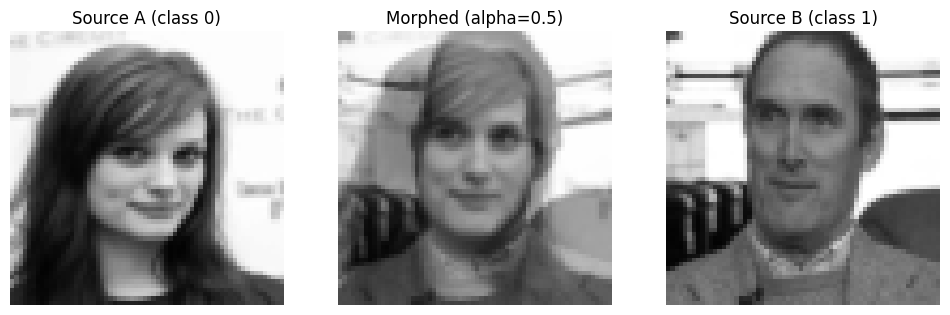

In [6]:
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt
import kagglehub
import os
from pathlib import Path
import urllib.request
import bz2

# ------------------ Configuration ------------------
# Chemin local pour Windows
LOCAL_DATA_DIR = Path("./dlib_models")
LOCAL_DATA_DIR.mkdir(exist_ok=True)
PREDICTOR_PATH = LOCAL_DATA_DIR / "shape_predictor_68_face_landmarks.dat"

UPSCALE = 4                 # facteur d'upscale depuis 64 -> 256
ORIG_SIZE = 64
SIZE = ORIG_SIZE * UPSCALE  # 256 si UPSCALE=4
ALPHA = 0.5                 # morph ratio 0..1

# ------------------ Télécharger le modèle Dlib automatiquement ------------------
def download_dlib_predictor():
    """Télécharge le fichier shape_predictor_68_face_landmarks.dat si nécessaire"""
    if PREDICTOR_PATH.exists():
        print(f"Modèle Dlib déjà présent : {PREDICTOR_PATH}")
        return
    
    print("Téléchargement du modèle Dlib shape_predictor_68_face_landmarks.dat...")
    url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    compressed_file = LOCAL_DATA_DIR / "shape_predictor_68_face_landmarks.dat.bz2"
    
    try:
        # Télécharger le fichier compressé
        urllib.request.urlretrieve(url, compressed_file)
        print("Téléchargement terminé. Décompression...")
        
        # Décompresser
        with bz2.BZ2File(compressed_file, 'rb') as f_in:
            with open(PREDICTOR_PATH, 'wb') as f_out:
                f_out.write(f_in.read())
        
        # Supprimer le fichier compressé
        compressed_file.unlink()
        print(f"Modèle Dlib prêt : {PREDICTOR_PATH}")
        
    except Exception as e:
        raise RuntimeError(f"Erreur lors du téléchargement du modèle Dlib : {e}")

# Télécharger le modèle si nécessaire
download_dlib_predictor()

# ------------------ Charger Dlib ------------------
try:
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(str(PREDICTOR_PATH))
    print("Modèle Dlib chargé avec succès !")
except Exception as e:
    raise RuntimeError(f"Impossible de charger Dlib predictor: {e}")
# ------------------ Fonctions utilitaires ------------------

def upscale_image(img, size=SIZE):
    """Upscale image (64x64) -> (size,size) using interpolation bicubic."""
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)

def get_landmarks(img_gray, detector, predictor, upsample_times=1):
    """
    Renvoie un array (68,2) de landmarks en int32 si détection ok.
    Si échec, retourne None.
    img_gray doit être une image grayscale (H,W), preferably upscaled.
    """
    dets = detector(img_gray, upsample_times)
    if len(dets) == 0:
        return None
    shape = predictor(img_gray, dets[0])
    pts = np.zeros((68, 2), dtype=np.int32)
    for i in range(68):
        pts[i] = (shape.part(i).x, shape.part(i).y)
    return pts

def add_corner_points(points, w, h):
    """
    Concatène 8 points de bord: 4 coins et 4 centres de bord.
    points: (N,2) numpy
    Retourne (N+8,2).
    """
    corners = np.array([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1],
        [w // 2, 0],
        [w - 1, h // 2],
        [w // 2, h - 1],
        [0, h // 2]
    ], dtype=np.int32)
    return np.concatenate([points, corners], axis=0)

def clamp_points(points, w, h):
    pts = np.array(points, dtype=np.float32)
    pts[:, 0] = np.clip(pts[:, 0], 0, w - 1)
    pts[:, 1] = np.clip(pts[:, 1], 0, h - 1)
    return pts

def find_point_index(points, pt, tol=3.0):
    """
    Trouve l'index du point de 'points' le plus proche de 'pt'.
    Retourne None si la distance minimale > tol.
    """
    pts = np.asarray(points, dtype=np.float32)
    dists = np.linalg.norm(pts - np.asarray(pt, dtype=np.float32), axis=1)
    idx = int(np.argmin(dists))
    if dists[idx] <= tol:
        return idx
    return None

def triangle_completely_inside(t, w, h):
    """vrai si tous les sommets du triangle t sont dans l'image"""
    for (x, y) in t:
        if x < 0 or x >= w or y < 0 or y >= h:
            return False
    return True

def apply_affine_transform(src, src_tri, dst_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    dst = cv2.warpAffine(src, warp_mat, (int(size[0]), int(size[1])),
                         None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return dst

def morph_triangle(img1, img2, img_morphed, t1, t2, t_morphed, alpha):
    # bounding rects
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t_morphed]))

    # verify non-empty
    if r1[2] <= 0 or r1[3] <= 0 or r2[2] <= 0 or r2[3] <= 0 or r[2] <= 0 or r[3] <= 0:
        return  # skip

    # offsets
    t1_rect = [(t1[i][0] - r1[0], t1[i][1] - r1[1]) for i in range(3)]
    t2_rect = [(t2[i][0] - r2[0], t2[i][1] - r2[1]) for i in range(3)]
    t_rect = [(t_morphed[i][0] - r[0], t_morphed[i][1] - r[1]) for i in range(3)]

    # crop patches
    img1_rect = img1[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    img2_rect = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]]

    if img1_rect.size == 0 or img2_rect.size == 0:
        return

    size_rect = (r[2], r[3])

    warp_img1 = apply_affine_transform(img1_rect, t1_rect, t_rect, size_rect)
    warp_img2 = apply_affine_transform(img2_rect, t2_rect, t_rect, size_rect)

    img_rect = (1.0 - alpha) * warp_img1 + alpha * warp_img2

    # mask
    mask = np.zeros((r[3], r[2]), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(t_rect), 1.0, 16, 0)

    # copy into output
    y, x, w_rect, h_rect = r[1], r[0], r[2], r[3]
    # ensure dtype compatibility
    img_morphed[y:y+h_rect, x:x+w_rect] = img_morphed[y:y+h_rect, x:x+w_rect] * (1 - mask[:, :, None]) + img_rect * mask[:, :, None]

# ------------------ Pipeline principal ------------------

def prepare_points_for_image(img_gray, detector, predictor, w, h):
    """
    Retourne un array de taille (76,2) (68 landmarks + 8 coins) float32.
    Si Dlib échoue, on met un placeholder (centres) puis on ajoute coins.
    """
    pts = get_landmarks(img_gray, detector, predictor, upsample_times=1)
    if pts is None:
        # placeholder : distribuer 68 points au centre approximatif (évite NaN)
        print("Avertissement : Aucun visage détecté par Dlib. Utilisation de placeholders + coins.")
        # simple grille de points au milieu (placeholder stable)
        grid_x = np.tile(np.linspace(w*0.25, w*0.75, 17), (4,))
        grid_y = np.repeat(np.linspace(h*0.25, h*0.75, 4), 17)
        grid = np.vstack([grid_x[:68], grid_y[:68]]).T.astype(np.int32)
        pts = grid
    # on a (68,2)
    pts = clamp_points(pts, w, h)
    pts = add_corner_points(pts.astype(np.int32), w, h)   # (76,2)
    return pts.astype(np.float32)

# ------------------ Sélection des images ------------------
try:
    idx_a = np.where(labels == CLASS_A)[0][0]
    idx_b = np.where(labels == CLASS_B)[0][0]
except Exception as e:
    raise IndexError(f"Classe {CLASS_A} ou {CLASS_B} non trouvée: {e}")

imgA = images[idx_a]
imgB = images[idx_b]

# upscale grayscale
imgA_up = upscale_image(imgA)
imgB_up = upscale_image(imgB)

# convert to 3-channel float for color blending (we'll keep grayscale -> replicate channels)
imgA_color = cv2.cvtColor(imgA_up, cv2.COLOR_GRAY2BGR).astype(np.float32)
imgB_color = cv2.cvtColor(imgB_up, cv2.COLOR_GRAY2BGR).astype(np.float32)

# prepare points
ptsA = prepare_points_for_image(imgA_up, detector, predictor, SIZE, SIZE)  # (76,2)
ptsB = prepare_points_for_image(imgB_up, detector, predictor, SIZE, SIZE)  # (76,2)

# ensure shapes
assert ptsA.shape[0] == ptsB.shape[0], "Nombre de points differents (debug)."

# compute morphed points
points_morphed = (1.0 - ALPHA) * ptsA + ALPHA * ptsB
points_morphed = clamp_points(points_morphed, SIZE, SIZE)

# ------------------ Delaunay triangulation sur points_morphed ------------------
rect = (0, 0, SIZE, SIZE)
subdiv = cv2.Subdiv2D(rect)

# safer insertion: only points strictly inside rect
for p in points_morphed:
    x, y = float(p[0]), float(p[1])
    if 0 <= x < SIZE and 0 <= y < SIZE:
        subdiv.insert((x, y))

triangle_list = subdiv.getTriangleList()  # liste de triangles en coordonnées (x1,y1,x2,y2,x3,y3)

# Pour chaque triangle, retrouver les indices des 3 points (nearest neighbor)
tri_indices = []
for t in triangle_list:
    tri_pts = [(t[0], t[1]), (t[2], t[3]), (t[4], t[5])]
    inds = []
    valid = True
    for p in tri_pts:
        idx = find_point_index(points_morphed, p, tol=5.0)
        if idx is None:
            valid = False
            break
        inds.append(idx)
    if valid and len(set(inds)) == 3:
        tri_indices.append(tuple(inds))

# dédupliquer les triangles
tri_indices = list(set(tri_indices))
print(f"Triangles valides trouvés: {len(tri_indices)}")

# ------------------ Morphing triangle par triangle ------------------
img_morphed = np.zeros_like(imgA_color, dtype=np.float32)

for tri in tri_indices:
    i1, i2, i3 = tri
    tA = [ptsA[i1], ptsA[i2], ptsA[i3]]
    tB = [ptsB[i1], ptsB[i2], ptsB[i3]]
    tM = [points_morphed[i1], points_morphed[i2], points_morphed[i3]]

    # skip si triangle hors image
    if not (triangle_completely_inside(tA, SIZE, SIZE) and triangle_completely_inside(tB, SIZE, SIZE) and triangle_completely_inside(tM, SIZE, SIZE)):
        continue

    morph_triangle(imgA_color, imgB_color, img_morphed, tA, tB, tM, ALPHA)

# ------------------ Affichage ------------------
# convert to uint8
imgA_show = np.clip(imgA_color, 0, 255).astype(np.uint8)
imgB_show = np.clip(imgB_color, 0, 255).astype(np.uint8)
imgM_show = np.clip(img_morphed, 0, 255).astype(np.uint8)

# downscale to original for compact display (optionnel)
imgA_disp = cv2.resize(imgA_show, (ORIG_SIZE, ORIG_SIZE), interpolation=cv2.INTER_AREA)
imgB_disp = cv2.resize(imgB_show, (ORIG_SIZE, ORIG_SIZE), interpolation=cv2.INTER_AREA)
imgM_disp = cv2.resize(imgM_show, (ORIG_SIZE, ORIG_SIZE), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title(f"Source A (class {CLASS_A})"); plt.imshow(cv2.cvtColor(imgA_disp, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1,3,2); plt.title(f"Morphed (alpha={ALPHA})"); plt.imshow(cv2.cvtColor(imgM_disp, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1,3,3); plt.title(f"Source B (class {CLASS_B})"); plt.imshow(cv2.cvtColor(imgB_disp, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

In [8]:
import subprocess
import sys

# Désinstaller TensorFlow complètement
try:
    subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "tensorflow", "tensorflow-cpu", "tensorflow-gpu", "tf-nightly"], check=False)
    print("Désinstallation terminée")
except:
    pass

# Installer une version compatible de TensorFlow
try:
    subprocess.run([sys.executable, "-m", "pip", "install", "tensorflow==2.16.1"], check=True)
    print("Installation de TensorFlow 2.16.1 réussie")
except:
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", "tensorflow"], check=True)
        print("Installation de TensorFlow version la plus récente réussie")
    except Exception as e:
        print(f"Erreur lors de l'installation: {e}")

# Vérifier l'installation
try:
    import tensorflow as tf
    print(f"TensorFlow {tf.__version__} installé avec succès!")
    print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")
except ImportError as e:
    print(f"Erreur d'importation: {e}")

Désinstallation terminée
Installation de TensorFlow 2.16.1 réussie
Erreur d'importation: DLL load failed while importing _pywrap_toco_api: La procédure spécifiée est introuvable.


Version avec scikit-learn MLPClassifier
Path to dataset files: C:\Users\marwa\.cache\kagglehub\datasets\hearfool\vggface2\versions\1
Chargement du dataset VGGFace2...
Chargement des données depuis: C:\Users\marwa\.cache\kagglehub\datasets\hearfool\vggface2\versions\1\train


Scanning folders:   6%|▌         | 29/480 [00:00<00:01, 260.49it/s]


Personnes valides trouvées: 30


Loading images: 100%|██████████| 30/30 [01:32<00:00,  3.09s/it]


Images chargées: (10104, 4096)
Labels: (10104,)
Nombre de classes: 30
Données d'entraînement: (8083, 4096)
Données de test: (2021, 4096)

Entraînement du réseau de neurones MLPClassifier...
Iteration 1, loss = 3.04115553
Validation score: 0.212608
Iteration 2, loss = 2.43423383
Validation score: 0.285538
Iteration 3, loss = 2.11698881
Validation score: 0.337454
Iteration 4, loss = 1.87127548
Validation score: 0.349815
Iteration 5, loss = 1.65184821
Validation score: 0.375773
Iteration 6, loss = 1.45196376
Validation score: 0.391842
Iteration 7, loss = 1.29916305
Validation score: 0.372064
Iteration 8, loss = 1.09134793
Validation score: 0.379481
Iteration 9, loss = 0.98882782
Validation score: 0.375773
Iteration 10, loss = 0.93434961
Validation score: 0.368356
Iteration 11, loss = 0.80364285
Validation score: 0.390606
Iteration 12, loss = 0.70021700
Validation score: 0.394314
Iteration 13, loss = 0.63686523
Validation score: 0.393078
Iteration 14, loss = 0.69209084
Validation score: 0.

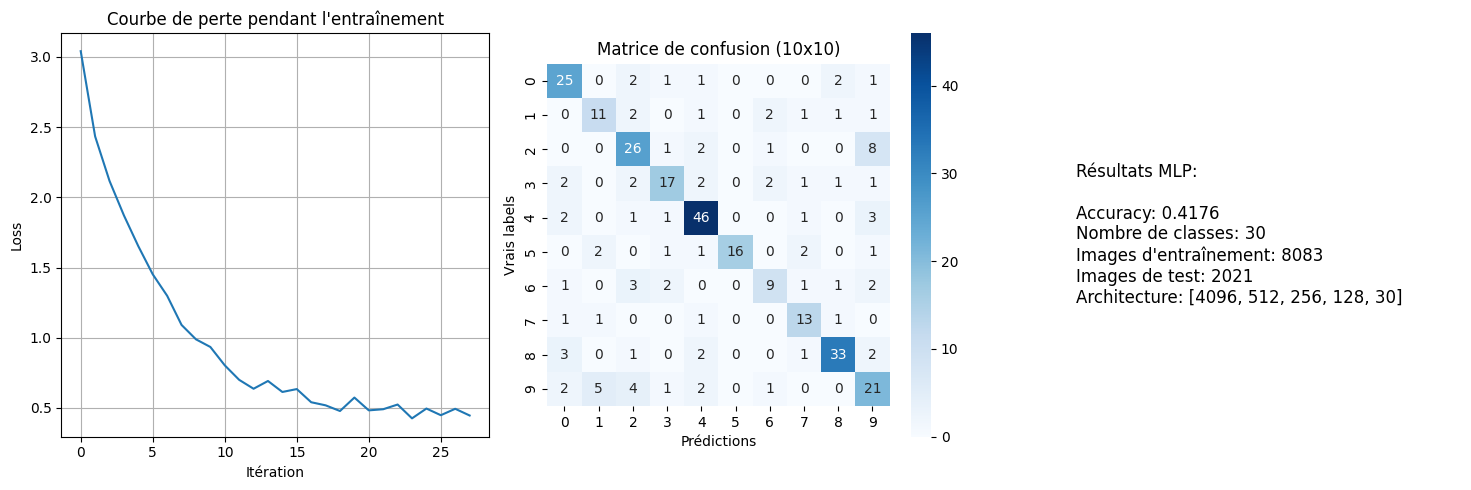


Entraînement MLP terminé!
Accuracy finale: 0.4176


In [10]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import cv2
import kagglehub
from pathlib import Path
from tqdm import tqdm

print("Version avec scikit-learn MLPClassifier")

# ------------------ Configuration ------------------
IMG_SIZE = 64  # Taille plus petite pour MLPClassifier
MAX_PEOPLE = 30  # Limiter pour performance
MIN_IMAGES_PER_PERSON = 8
VALIDATION_SPLIT = 0.2

# Télécharger VGGFace2
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

# ------------------ Chargement des données ------------------
def load_vggface2_for_mlp(dataset_path, max_people=MAX_PEOPLE, min_images_per_person=MIN_IMAGES_PER_PERSON):
    """
    Charge les images pour MLPClassifier (aplaties)
    """
    dataset_path = Path(dataset_path)
    
    # Chercher le dossier d'images
    possible_dirs = ["train", "test", "data"]
    image_root = None
    
    for dir_name in possible_dirs:
        potential_path = dataset_path / dir_name
        if potential_path.exists():
            image_root = potential_path
            break
    
    if image_root is None:
        image_root = dataset_path
    
    print(f"Chargement des données depuis: {image_root}")
    
    person_folders = [f for f in image_root.iterdir() if f.is_dir()]
    valid_people = []
    
    # Filtrer les personnes qui ont assez d'images
    for person_folder in tqdm(person_folders, desc="Scanning folders"):
        image_files = list(person_folder.glob("*.jpg")) + list(person_folder.glob("*.png"))
        if len(image_files) >= min_images_per_person:
            valid_people.append(person_folder)
        if len(valid_people) >= max_people:
            break
    
    print(f"Personnes valides trouvées: {len(valid_people)}")
    
    images = []
    labels = []
    class_names = []
    
    for person_id, person_folder in enumerate(tqdm(valid_people, desc="Loading images")):
        class_names.append(person_folder.name)
        image_files = list(person_folder.glob("*.jpg")) + list(person_folder.glob("*.png"))
        
        for img_file in image_files:
            try:
                # Charger en niveaux de gris
                img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Redimensionner et aplatir
                    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img_flat = img_resized.flatten()  # 64*64 = 4096 features
                    images.append(img_flat)
                    labels.append(person_id)
            except Exception as e:
                print(f"Erreur lors du chargement de {img_file}: {e}")
                continue
    
    return np.array(images), np.array(labels), class_names

# Charger les données
print("Chargement du dataset VGGFace2...")
X, y, class_names = load_vggface2_for_mlp(path)

print(f"Images chargées: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Nombre de classes: {len(class_names)}")

# Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X.astype('float32'))

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VALIDATION_SPLIT, random_state=42, stratify=y
)

print(f"Données d'entraînement: {X_train.shape}")
print(f"Données de test: {X_test.shape}")

# ------------------ Entraînement MLP ------------------
print("\nEntraînement du réseau de neurones MLPClassifier...")

# Créer le modèle
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # 3 couches cachées
    activation='relu',
    solver='adam',
    alpha=0.001,  # Régularisation L2
    batch_size=32,
    learning_rate='adaptive',
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=True
)

# Entraîner le modèle
mlp.fit(X_train, y_train)

# Prédictions
y_pred = mlp.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Visualisation
plt.figure(figsize=(15, 5))

# Courbe de perte
plt.subplot(1, 3, 1)
plt.plot(mlp.loss_curve_)
plt.title('Courbe de perte pendant l\'entraînement')
plt.xlabel('Itération')
plt.ylabel('Loss')
plt.grid(True)

# Matrice de confusion
plt.subplot(1, 3, 2)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues', square=True)  # Afficher seulement 10x10
plt.title('Matrice de confusion (10x10)')
plt.ylabel('Vrais labels')
plt.xlabel('Prédictions')

# Statistiques
plt.subplot(1, 3, 3)
plt.axis('off')
plt.text(0.1, 0.5, f'Résultats MLP:\n\nAccuracy: {accuracy:.4f}\nNombre de classes: {len(class_names)}\nImages d\'entraînement: {len(X_train)}\nImages de test: {len(X_test)}\nArchitecture: [4096, 512, 256, 128, {len(class_names)}]', 
         fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()

print(f"\nEntraînement MLP terminé!")
print(f"Accuracy finale: {accuracy:.4f}")

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import cv2
import kagglehub
from pathlib import Path
from tqdm import tqdm

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

# ------------------ Configuration ------------------
BATCH_SIZE = 32
IMG_SIZE = 224  # Taille d'entrée pour MobileNet
EPOCHS = 10
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
MAX_PEOPLE = 50  # Limiter le nombre de personnes pour l'entraînement
MIN_IMAGES_PER_PERSON = 10  # Minimum d'images par personne

# Télécharger VGGFace2
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

# ------------------ Chargement et préparation des données ------------------
def load_vggface2_for_training(dataset_path, max_people=MAX_PEOPLE, min_images_per_person=MIN_IMAGES_PER_PERSON):
    """
    Charge les images VGGFace2 pour l'entraînement de classification
    Returns: (images, labels, class_names)
    """
    dataset_path = Path(dataset_path)
    
    # Chercher le dossier d'images
    possible_dirs = ["train", "test", "data"]
    image_root = None
    
    for dir_name in possible_dirs:
        potential_path = dataset_path / dir_name
        if potential_path.exists():
            image_root = potential_path
            break
    
    if image_root is None:
        image_root = dataset_path
    
    print(f"Chargement des données depuis: {image_root}")
    
    person_folders = [f for f in image_root.iterdir() if f.is_dir()]
    valid_people = []
    
    # Filtrer les personnes qui ont assez d'images
    for person_folder in tqdm(person_folders, desc="Scanning folders"):
        image_files = list(person_folder.glob("*.jpg")) + list(person_folder.glob("*.png"))
        if len(image_files) >= min_images_per_person:
            valid_people.append(person_folder)
        if len(valid_people) >= max_people:
            break
    
    print(f"Personnes valides trouvées: {len(valid_people)}")
    
    images = []
    labels = []
    class_names = []
    
    for person_id, person_folder in enumerate(tqdm(valid_people, desc="Loading images")):
        class_names.append(person_folder.name)
        image_files = list(person_folder.glob("*.jpg")) + list(person_folder.glob("*.png"))
        
        for img_file in image_files:
            try:
                # Charger l'image en couleur
                img = cv2.imread(str(img_file))
                if img is not None:
                    # Convertir BGR vers RGB
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Redimensionner pour MobileNet
                    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
                    images.append(img_resized)
                    labels.append(person_id)
            except Exception as e:
                print(f"Erreur lors du chargement de {img_file}: {e}")
                continue
    
    return np.array(images), np.array(labels), class_names

# Charger les données
print("Chargement du dataset VGGFace2...")
X, y, class_names = load_vggface2_for_training(path)

print(f"Images chargées: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Nombre de classes: {len(class_names)}")
print(f"Classes: {class_names[:10]}...")  # Afficher les 10 premières classes

# Normalisation des images
X = X.astype('float32') / 255.0

# Division train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VALIDATION_SPLIT, random_state=42, stratify=y
)

print(f"Données d'entraînement: {X_train.shape}")
print(f"Données de validation: {X_val.shape}")

# ------------------ Augmentation des données ------------------
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # Pas d'augmentation pour la validation

# ------------------ Construction du modèle MobileNetV2 ------------------
def create_mobilenet_model(num_classes, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """
    Crée un modèle MobileNetV2 pour la classification faciale
    """
    # Base MobileNetV2 pré-entraînée sur ImageNet
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Geler les couches de base pour le transfer learning
    base_model.trainable = False
    
    # Ajouter des couches personnalisées
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs, outputs)
    return model, base_model

# Créer le modèle
num_classes = len(class_names)
model, base_model = create_mobilenet_model(num_classes)

# Afficher l'architecture
model.summary()

# Compiler le modèle
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ------------------ Callbacks ------------------
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'best_mobilenet_vggface2.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# ------------------ Entraînement Phase 1: Transfer Learning ------------------
print("\n=== Phase 1: Transfer Learning (couches gelées) ===")

history_phase1 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS // 2,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
    validation_steps=len(X_val) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# ------------------ Entraînement Phase 2: Fine-tuning ------------------
print("\n=== Phase 2: Fine-tuning (couches dégelées) ===")

# Dégeler les dernières couches du modèle de base
base_model.trainable = True

# Geler les premières couches et ne fine-tuner que les dernières
fine_tune_at = len(base_model.layers) - 20

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompiler avec un learning rate plus faible
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continuer l'entraînement
history_phase2 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS // 2,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
    validation_steps=len(X_val) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])
)

# ------------------ Évaluation et visualisation ------------------

# Combiner les historiques
history = {}
for key in history_phase1.history.keys():
    history[key] = history_phase1.history[key] + history_phase2.history[key]

# Évaluation finale
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\nAccuracy finale sur validation: {test_accuracy:.4f}")

# Visualiser les courbes d'entraînement
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x=len(history_phase1.history['loss'])-1, color='r', linestyle='--', alpha=0.7, label='Fine-tuning starts')

plt.subplot(1, 3, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=len(history_phase1.history['loss'])-1, color='r', linestyle='--', alpha=0.7)

# Prédictions sur quelques échantillons
predictions = model.predict(X_val[:9])
predicted_classes = np.argmax(predictions, axis=1)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.text(0.1, 0.5, f'Résultats:\n\nAccuracy: {test_accuracy:.4f}\nNombre de classes: {num_classes}\nImages d\'entraînement: {len(X_train)}\nImages de validation: {len(X_val)}', 
         fontsize=12, verticalalignment='center')

plt.tight_layout()
plt.show()

# Afficher quelques prédictions
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_val[i])
    true_class = class_names[y_val[i]]
    pred_class = class_names[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]]
    
    color = 'green' if y_val[i] == predicted_classes[i] else 'red'
    plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}', 
              color=color, fontsize=8)
    plt.axis('off')

plt.suptitle('Exemples de prédictions')
plt.tight_layout()
plt.show()

# Sauvegarder le modèle final
model.save('mobilenet_vggface2_final.h5')
print("Modèle sauvegardé sous 'mobilenet_vggface2_final.h5'")

print(f"\nEntraînement terminé!")
print(f"Accuracy finale: {test_accuracy:.4f}")

ImportError: DLL load failed while importing _pywrap_toco_api: La procédure spécifiée est introuvable.